In [19]:
import datetime
import exifread
import matplotlib.pyplot as plt
import napari
import numpy as np
import numpy.ma as ma
import os
import tifffile

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib_scalebar import scalebar as sb
from pyneurotrace import filters as pnf
from pyneurotrace import notebook as pnb
from tqdm.notebook import trange, tqdm
from ScanImageTiffReader import ScanImageTiffReader
from scipy.signal import find_peaks
from skimage import data, draw
from skimage.restoration import denoise_tv_chambolle
from skimage.registration import phase_cross_correlation
import skimage.measure as measure
from scipy import ndimage as ndi



In [10]:
%gui qt5
plt.rcParams['figure.facecolor'] = 'white'

In [11]:
# Change output figure size
# ...needs to be in its own cell for some reason...

plt.rcParams['figure.figsize'] = [16, 10]

In [58]:
def returnStimList(file):
    stim_csv = np.loadtxt(open(file), delimiter=',')
    print(stim_csv[0,:])
    stim_list = []
    seconds = np.array([3600, 60, 1])
    for i in range(1, stim_csv.shape[0], 1):
        temp= (stim_csv[i,3:] - stim_csv[0,3:])
        stim_list.append(np.sum(temp*seconds))
    return stim_list

# Returns change in fluorescence over average fluorescence of ROI

def returnROITrace(video, mask):
    video_mask = video * mask
    video_mask[video_mask==0] = np.nan
    trace = np.zeros(video.shape[0])
    for i in range(video_mask.shape[0]):
        roi_avg = np.nanmean(video_mask[i, :, :])
        if np.isnan(roi_avg)==False:
            trace[i]= roi_avg
            lastNonNan = roi_avg
        else:
            trace[i]=lastNonNan
    return trace

# Offset correction
def returnOffsetCorr(movie):
    if np.min(movie)<0:
        movie = movie - np.min(movie)
    return movie




In [83]:
# CONSTANTS AND FILES
# PATH TO MOIVE FILE
FILE = '../GluSnfr3_210211/PDGFR (72hrs)/neuron-4/file_00003_87_95hz.tif'

# CSV FOR STIM TIME
STIM_FILE ='../GluSnfr3_210211/PDGFR (72hrs)/neuron-4/StimOutput02-11-2021 20-54.csv'


# Load the file
MOVIE = tifffile.imread(FILE)
print(MOVIE.shape)
if STIM_FILE is not None:
    STIM_LIST = returnStimList(STIM_FILE)
    
# Pull meta-data from the file    
metadata=ScanImageTiffReader(FILE).metadata()
metadata_dict = {}
metadata = metadata.split("\n")
for data in metadata:
    temp = data.split(" = ")
    if len(temp) > 1:
        metadata_dict[temp[0]] = temp[1]
        
        
# Saving the zoom of the factor      
ZOOM = metadata_dict['SI.hRoiManager.scanZoomFactor']
print('Image Zoom Facter: ', ZOOM)

# FRAME RATE
HZ = 87.95

# PIXEL VALUE IN REAL WORLD MEASUREMENTS (um)
PX = (162/MOVIE.shape[2])/int(ZOOM) 

# DFF FOR HOTSPOT DETECTION
THRESHOLD = .1

(14691, 30, 128)
[2.0210e+03 2.0000e+00 1.1000e+01 2.0000e+01 5.2000e+01 1.7478e+01]
Image Zoom Facter:  3
0.158203125


In [61]:
print(np.min(MOVIE), np.max(MOVIE))
MOVIE = returnOffsetCorr(MOVIE)
print(np.min(MOVIE), np.max(MOVIE))
# VIEW THE MOVIE
viewer = napari.Viewer()
viewer.add_image(MOVIE)

-85 2046
0 2131


<Image layer 'MOVIE' at 0x7f80a37fc358>

In [62]:
# SMOOTH TO HELP STABILIZE IT
smooth_movie = np.zeros(MOVIE.shape)
for i in trange(MOVIE.shape[0]):
    smooth_movie[i,:,:] = denoise_tv_chambolle(MOVIE[i,:,:], weight=.0005)

viewer = napari.Viewer()
viewer.add_image(smooth_movie)

<Image layer 'smooth_movie' at 0x7f80985cc3c8>

In [63]:
# CODE TO STABALIZE THE IMAGE USING PHASE CORRELATION

Stable_Image = np.zeros(MOVIE.shape)
Stable_Image[0, : : ] = MOVIE[0, :, :]

# COMPARES FRAMES AND CALCULATES THE DRIFT
for i in trange(MOVIE.shape[0]-1):
    shift, error, diffphase = phase_cross_correlation(smooth_movie[i, :,:], smooth_movie[(i+1),:,:], upsample_factor=100)
    # IF THE SHIFT IS GREATE THAN ZERO PIXELS APPLY A SHIFT TO THE ARRAY
    if (shift[0]> 0) or (shift[1] > 0):
        shifted_frame = ndi.interpolation.shift(MOVIE[(i+1),:,:], shift)
        Stable_Image[i+1, :,:] = shifted_frame
    else:
        Stable_Image[i+1, :,:] = MOVIE[(i+1),:,:]

In [64]:
# VIEW THE MOVIE, DETERMINE THE LAST FRAME BEFORE DRIFT IS TOO CRAZY
viewer = napari.Viewer()
viewer.add_image(Stable_Image)
print(Stable_Image.shape)

(14691, 30, 128)


In [65]:
# MANUALLY SET THE FRAMES TO PROCESS 
# SET AN INT FOR THE FIRST FRAME
FIRST_FRAME = 0

# SET AN INT FOR THE LAST FRAME
LAST_FRAME = 14691

stable = Stable_Image[FIRST_FRAME:LAST_FRAME,:,:]

# Remove Border 
stable = stable[:, 1:-1, 1:-1]
viewer = napari.Viewer()
viewer.add_image(stable)

if STIM_FILE is not None:
    stim2plot = []
    for stim in STIM_LIST:
        if (FIRST_FRAME/HZ) <= stim <= (LAST_FRAME/HZ):
            stim2plot.append(stim - (FIRST_FRAME/HZ))

[9.003, 18.07, 29.135999999999996, 38.202999999999996, 50.266999999999996, 60.331999999999994, 68.398, 77.464, 86.53, 96.59700000000001, 104.664, 114.733, 126.798, 135.863, 145.932, 156.997]


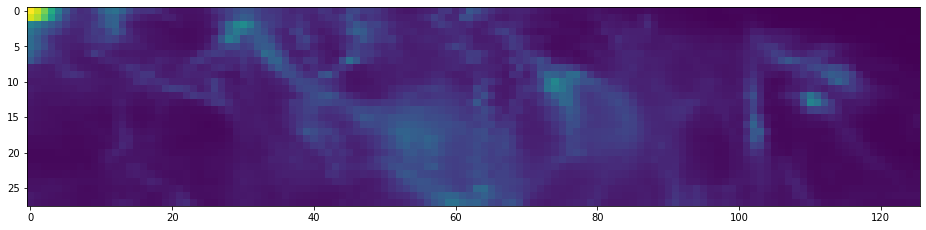

In [66]:
DENDRITE = np.std(stable, axis=0)
plt.imshow(DENDRITE)
print(stim2plot)

Hotspot_1


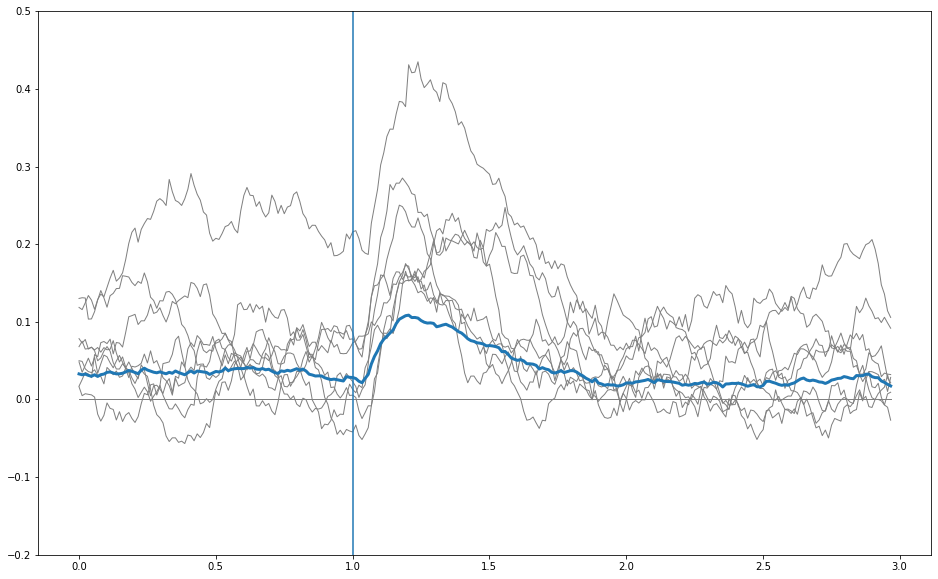

Hotspot_2


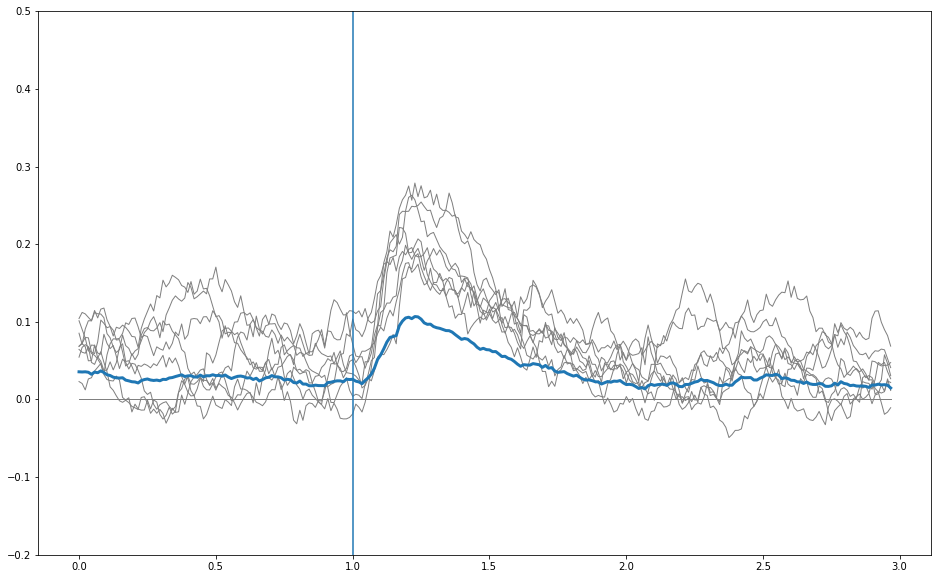

Hotspot_3


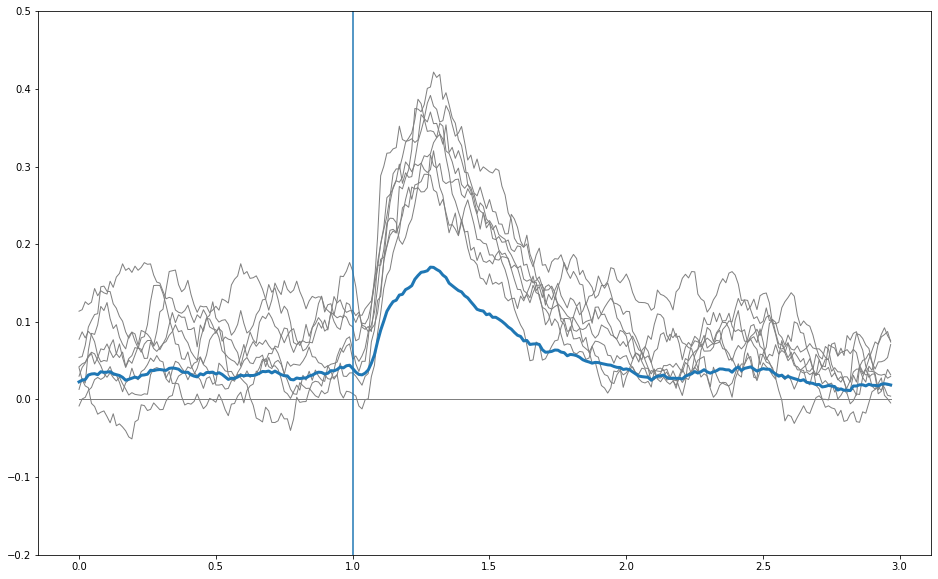

Hotspot_4


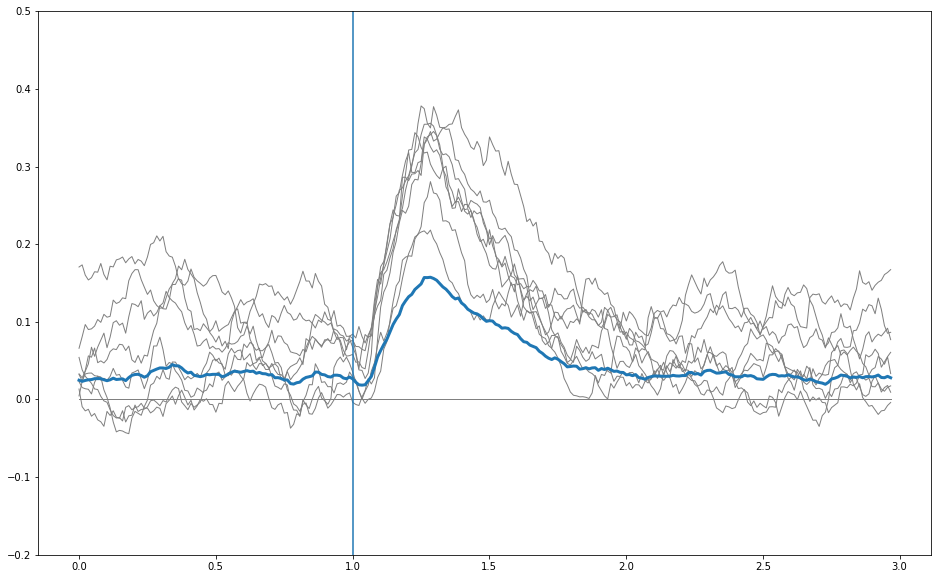

Hotspot_5


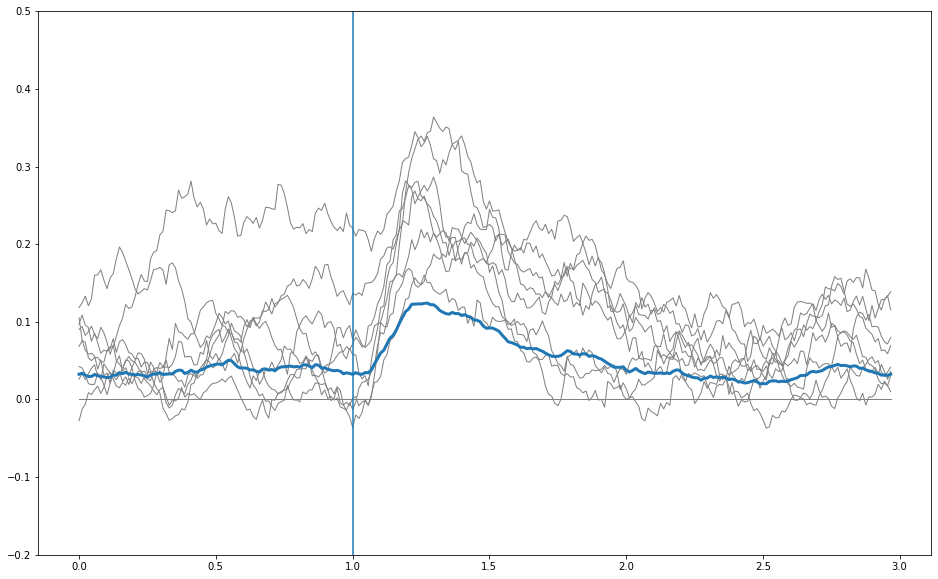

Hotspot_6


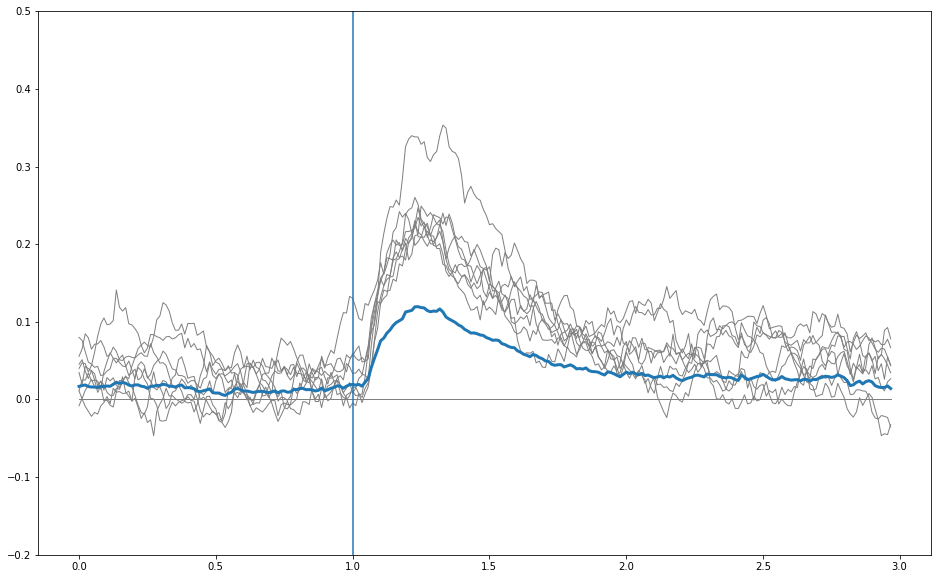

Hotspot_7


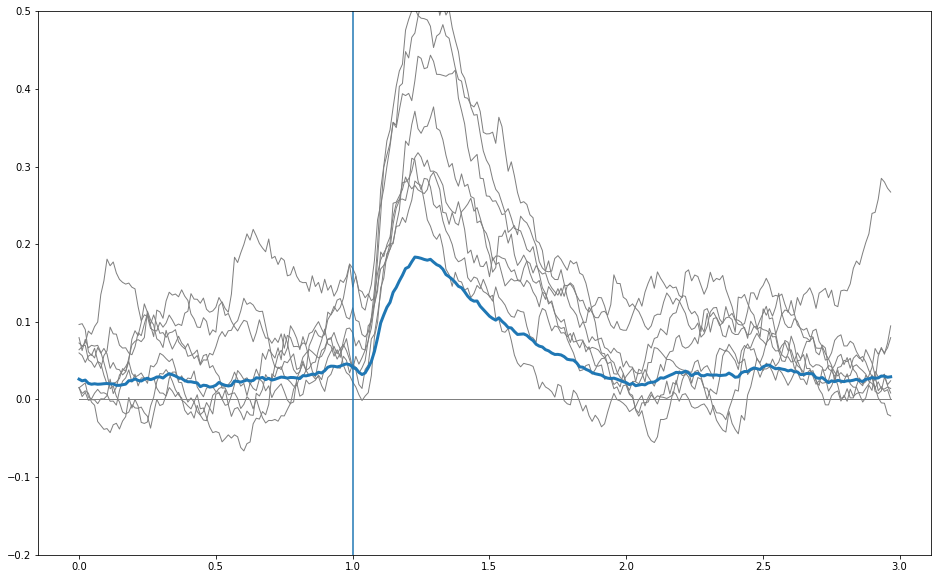

Hotspot_8


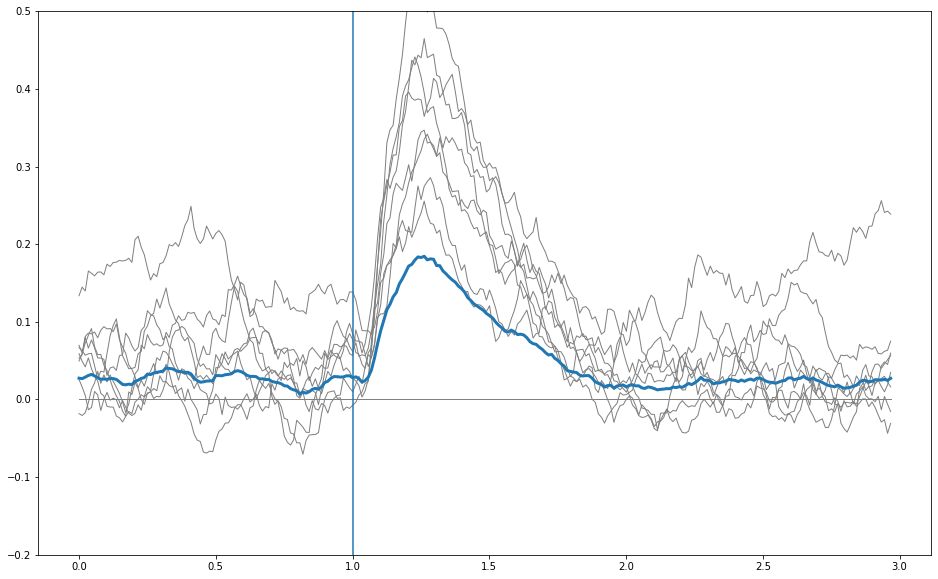

Hotspot_9


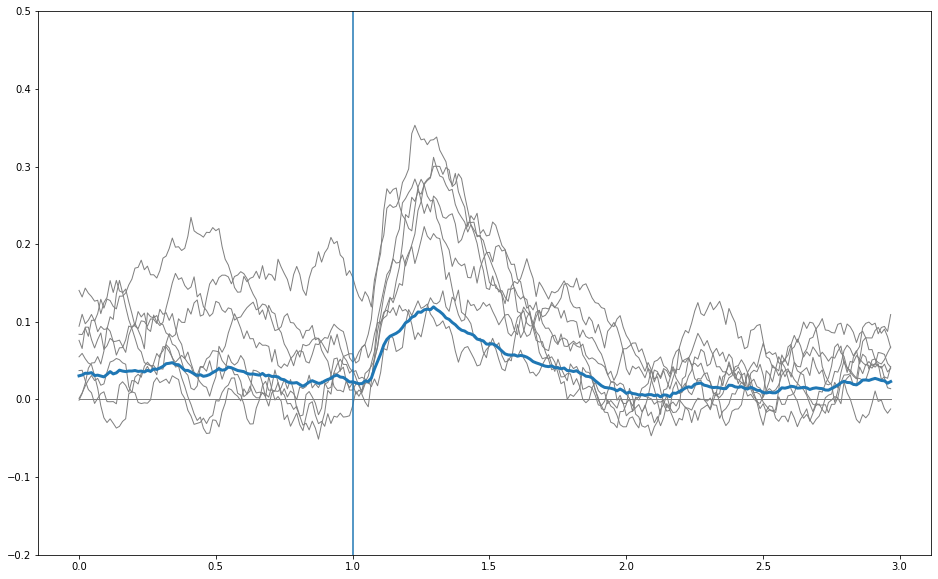

Hotspot_10


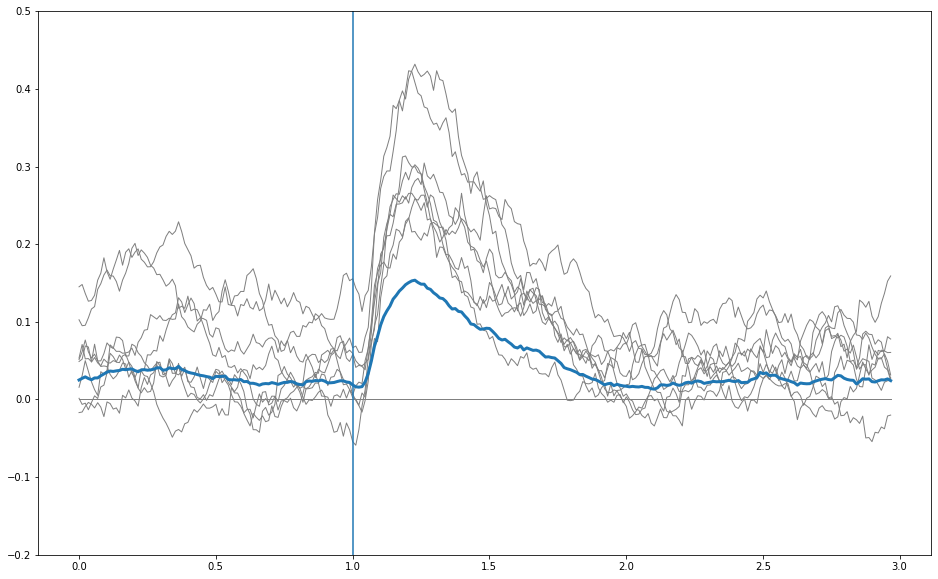

Hotspot_11


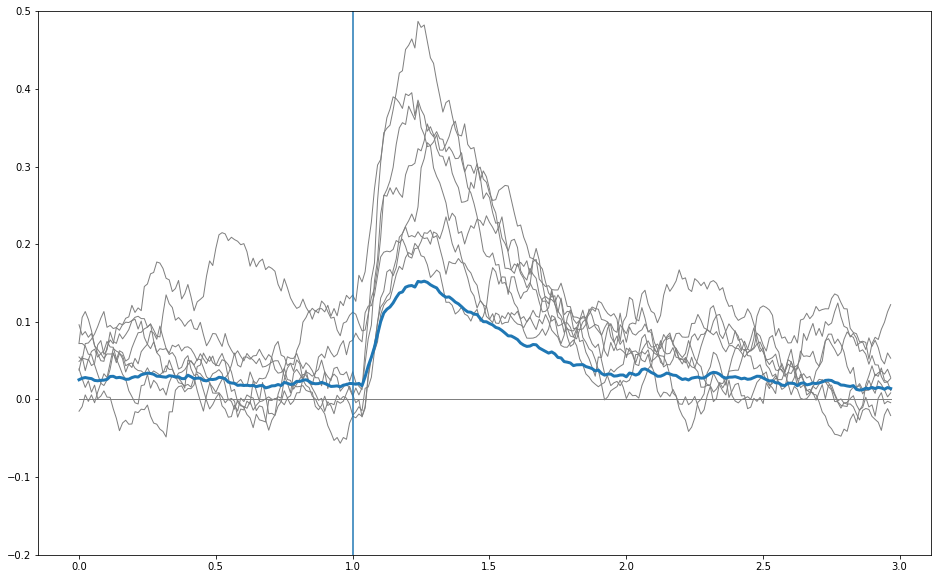

Hotspot_12


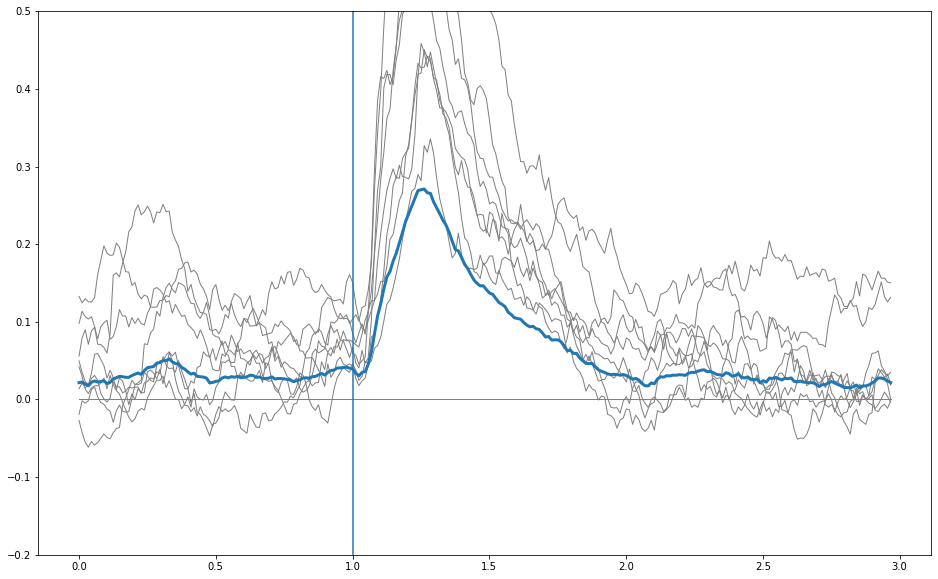

Hotspot_13


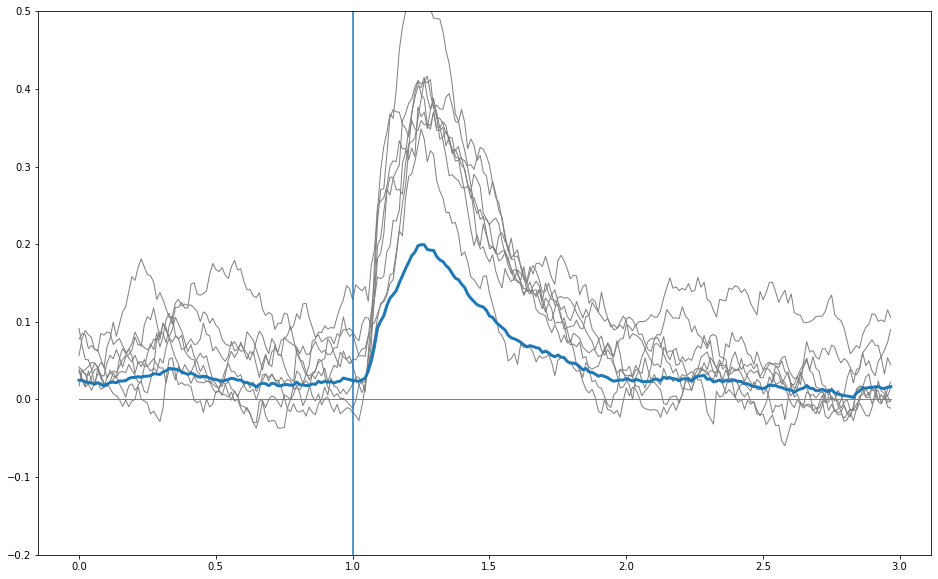

Hotspot_14


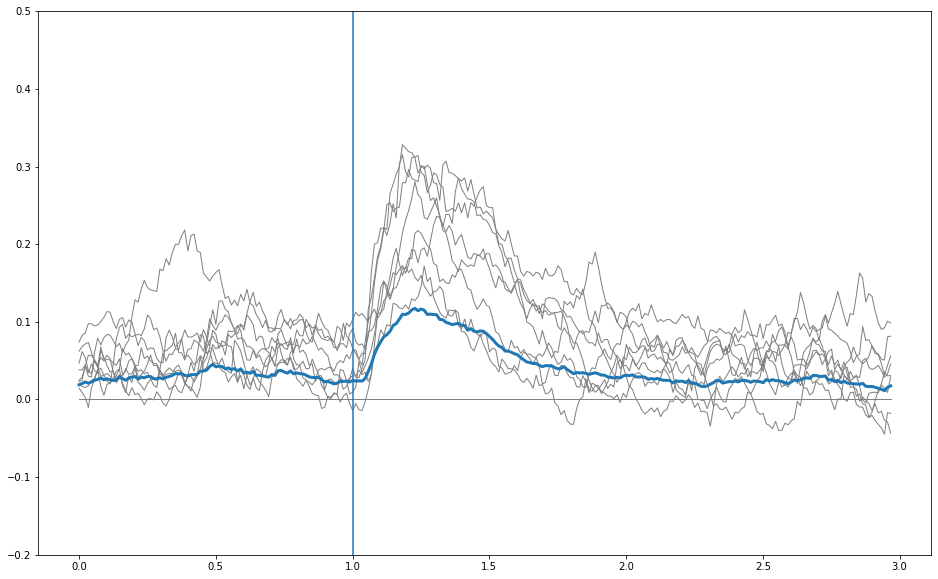

Hotspot_15


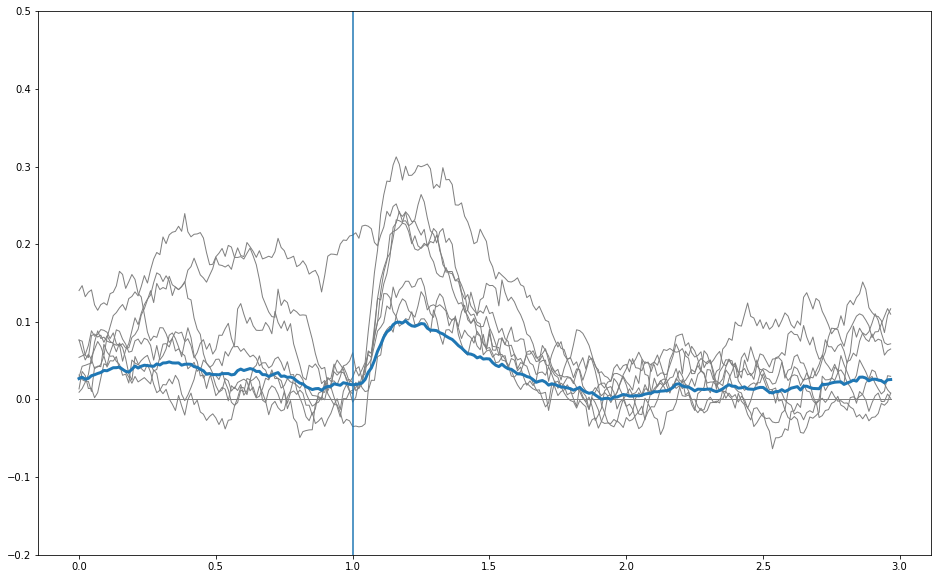

Hotspot_16


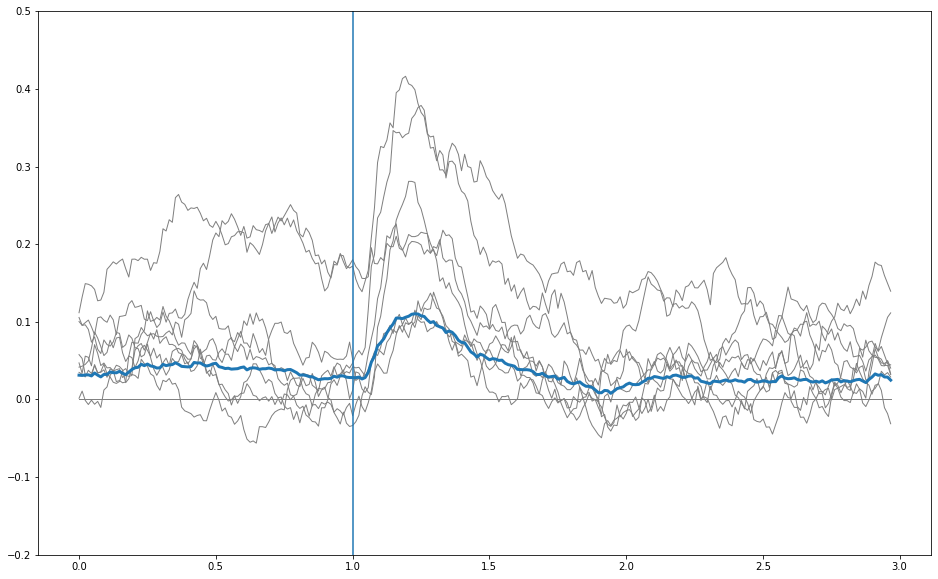

Hotspot_17


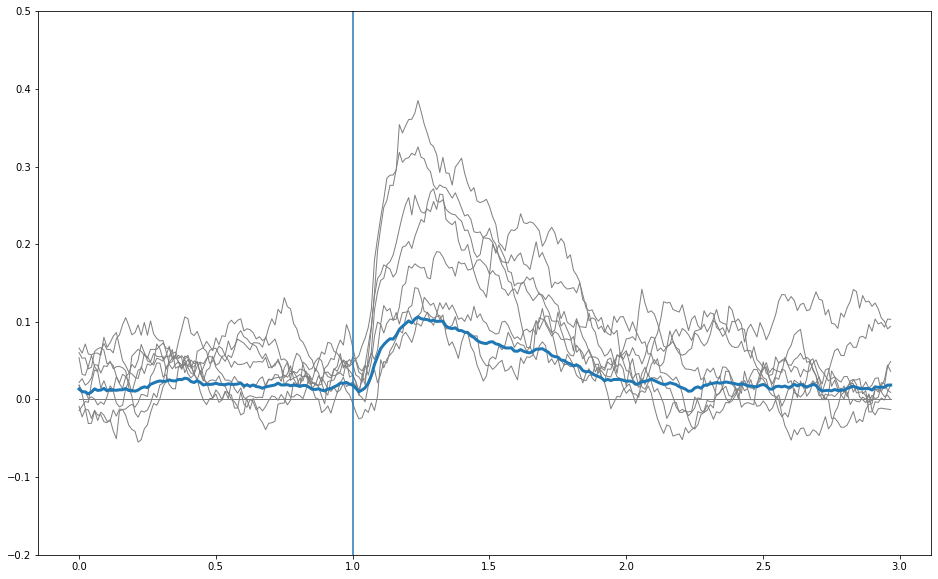

Hotspot_18


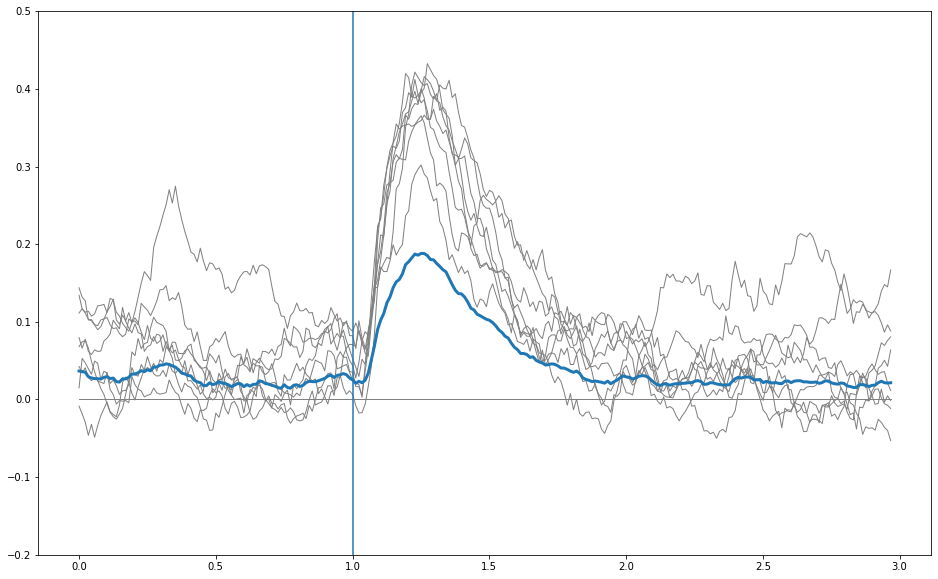

Hotspot_19


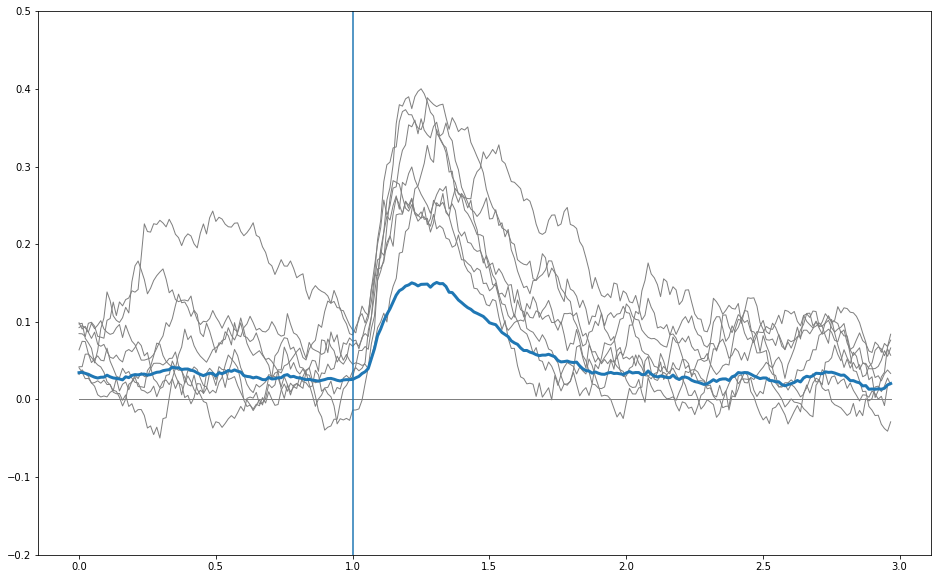

Hotspot_20


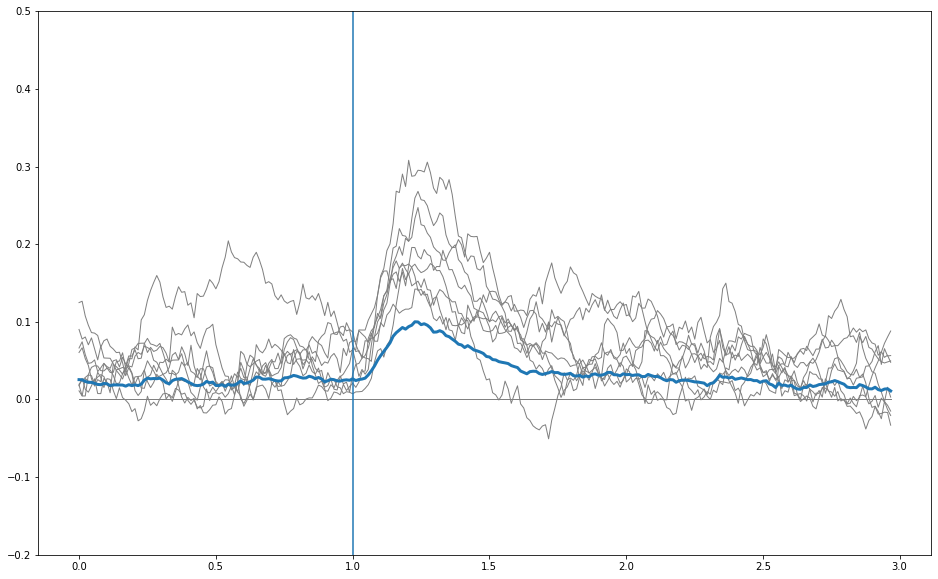

Hotspot_21


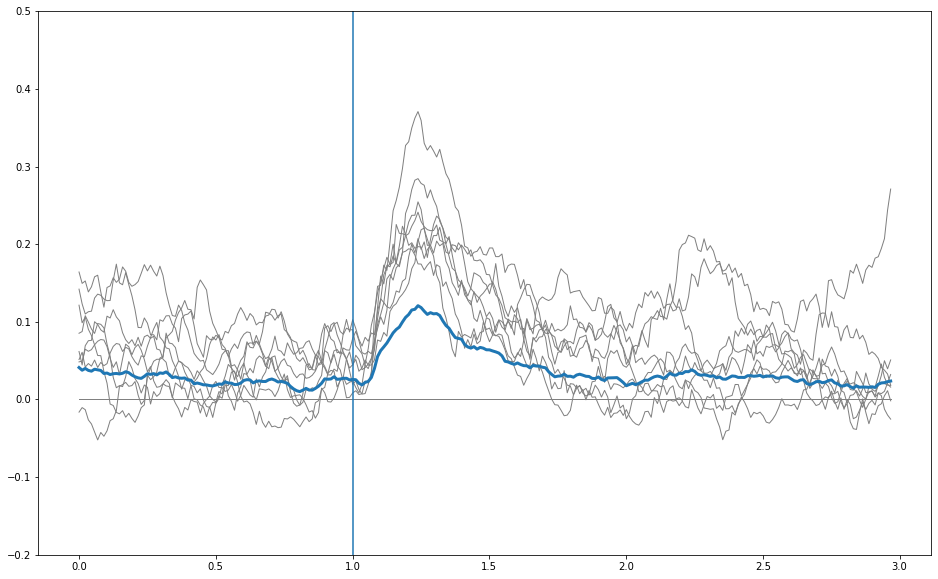

Hotspot_22


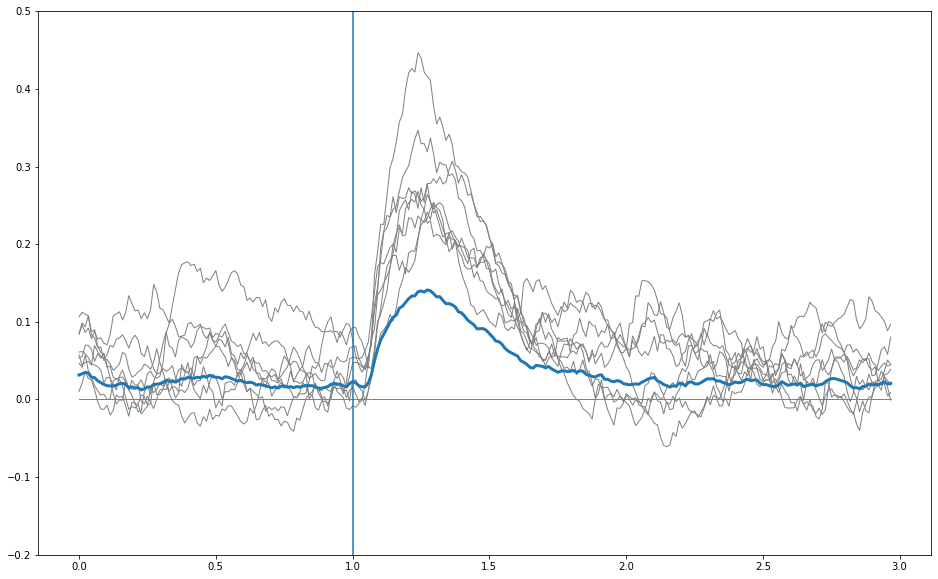

Hotspot_23


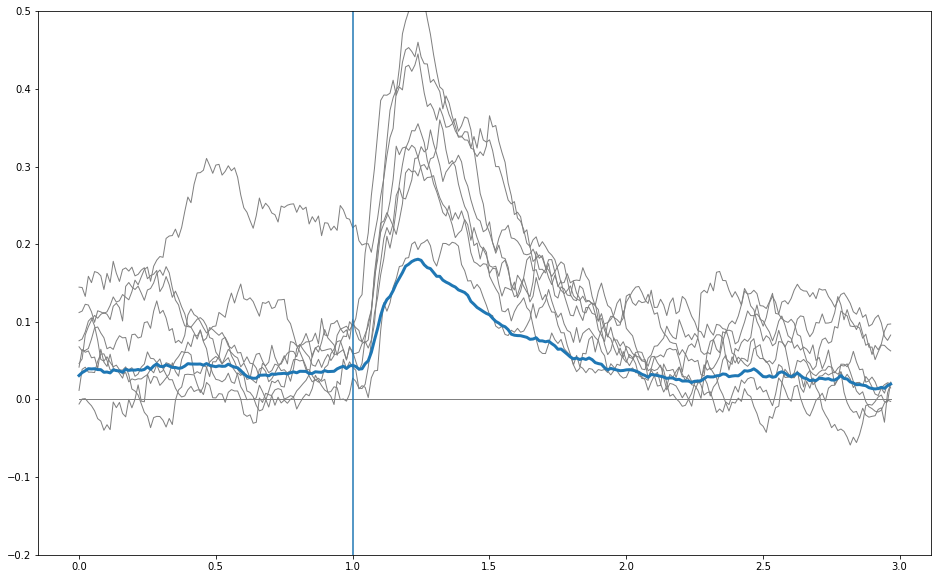

Hotspot_24


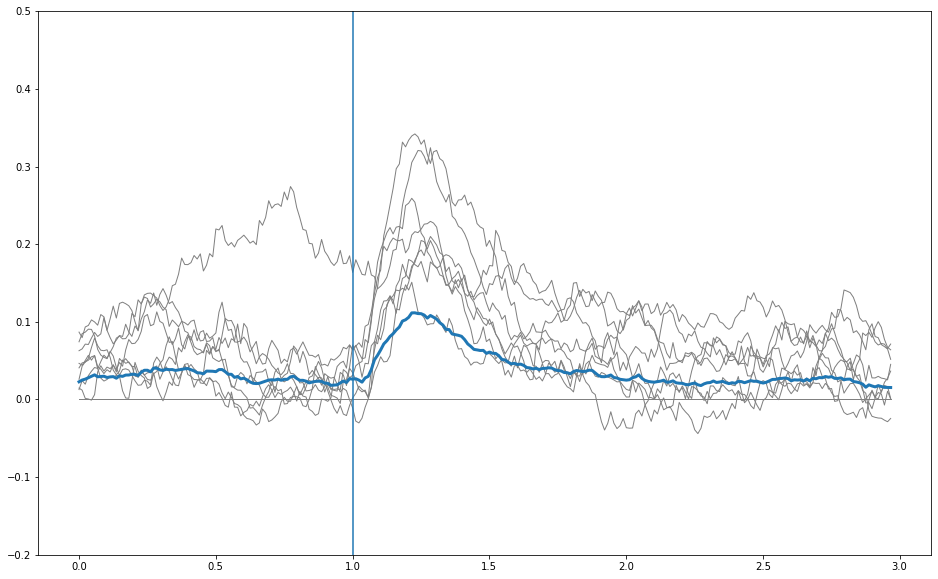

Hotspot_25


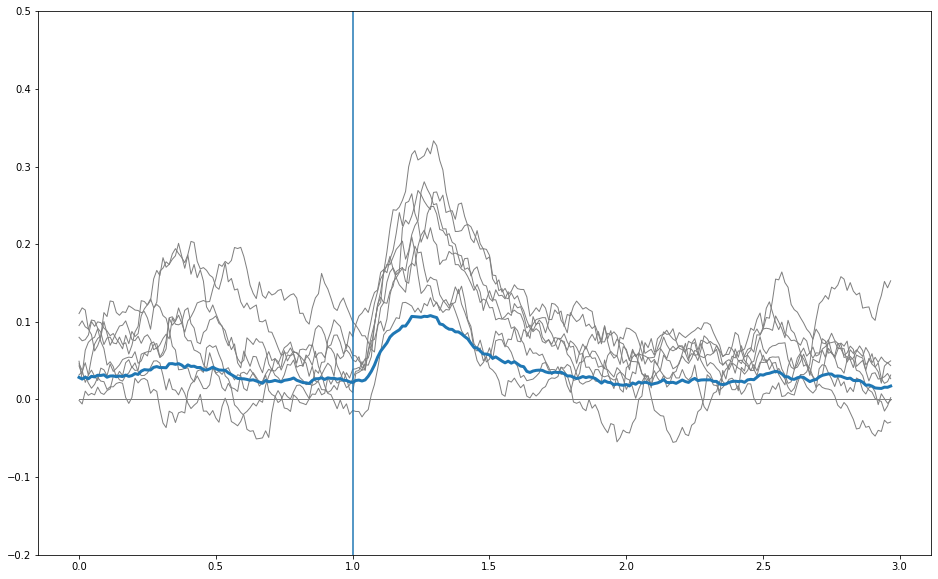

Hotspot_26


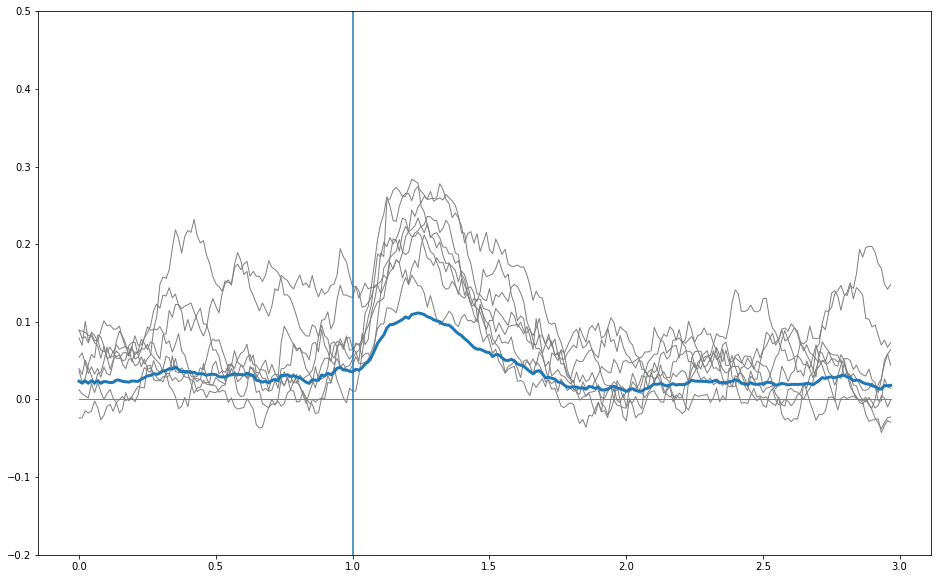

Hotspot_27


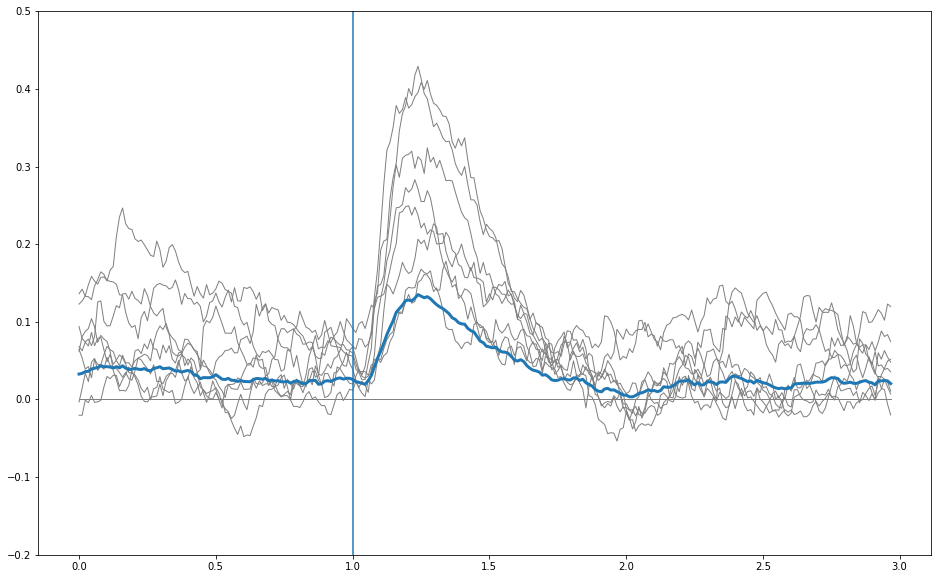

Hotspot_28


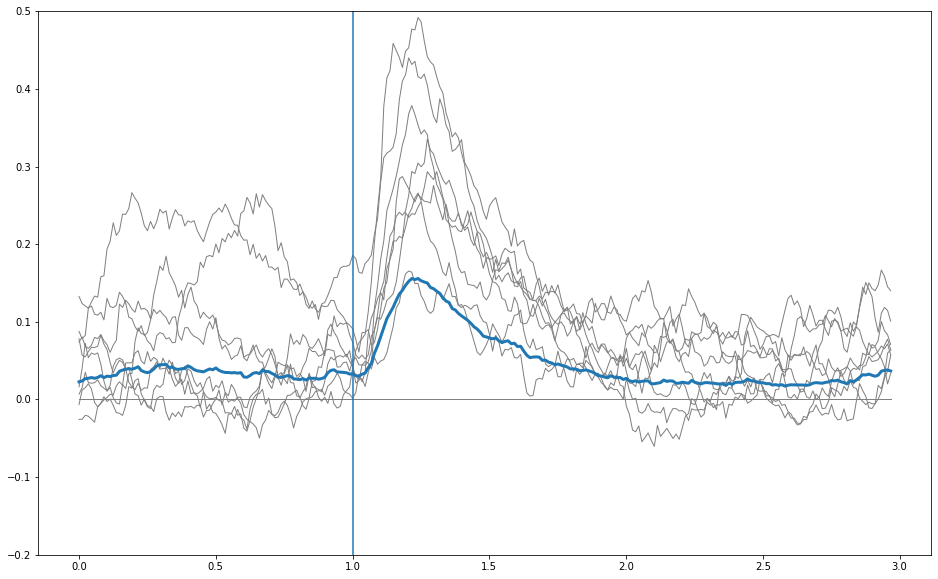

Hotspot_29


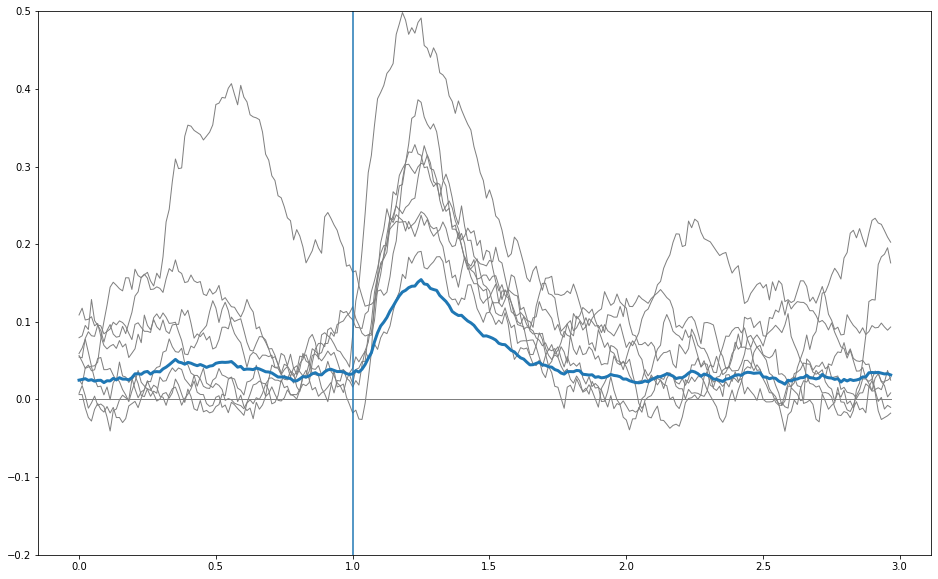

Hotspot_30


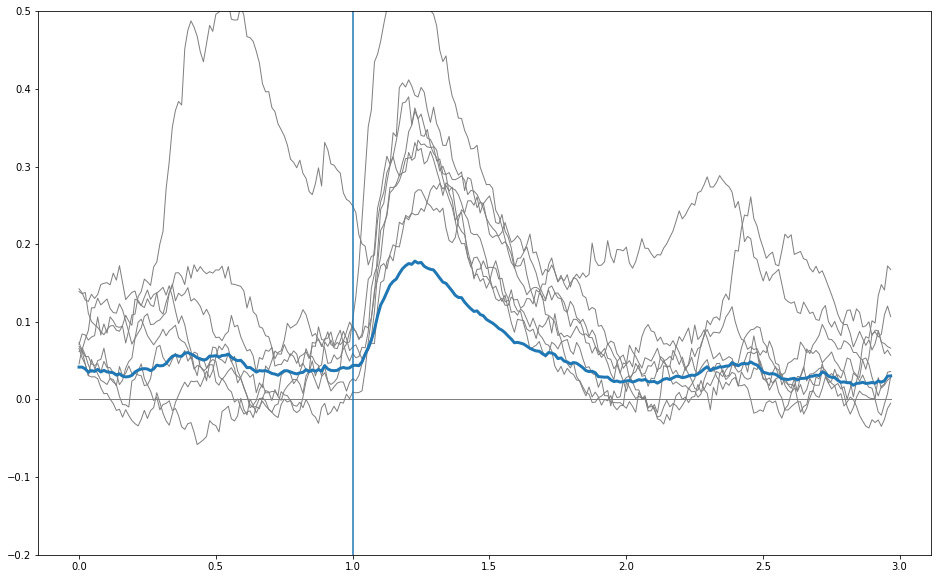

Hotspot_31


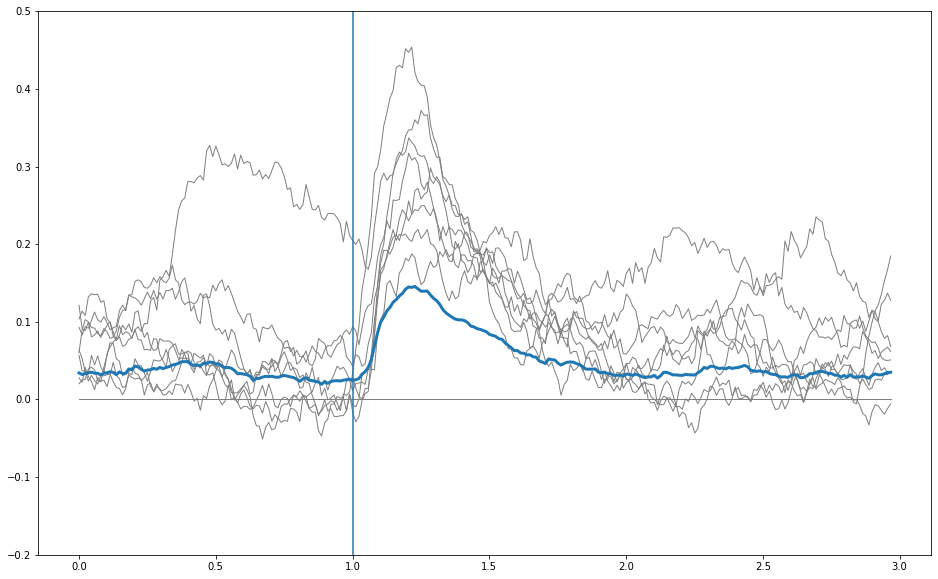

Hotspot_32


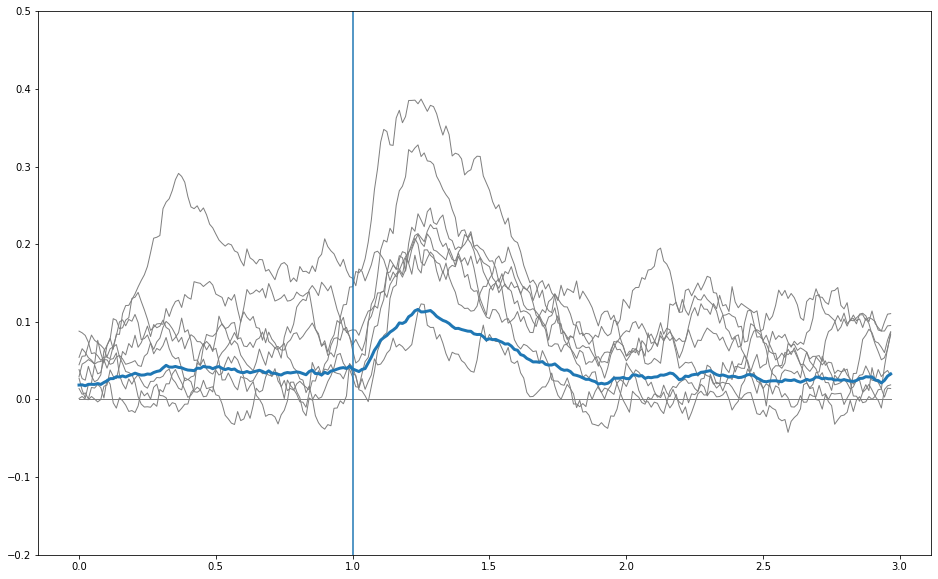

Hotspot_33


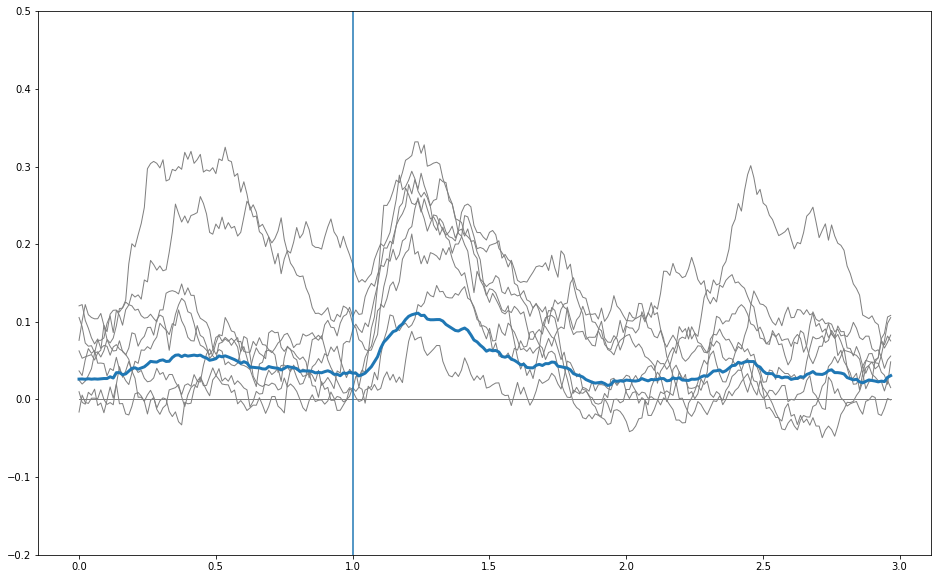

Hotspot_34


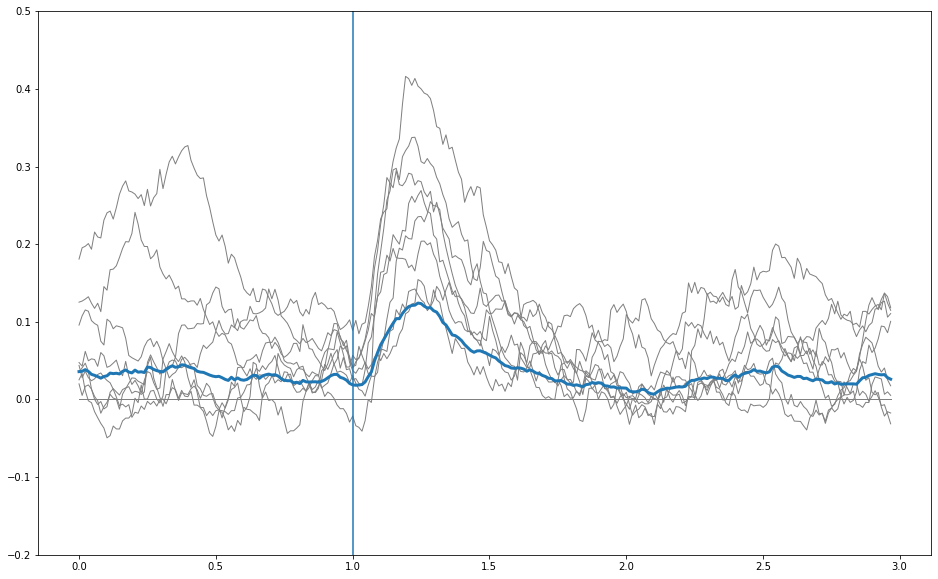

Hotspot_35


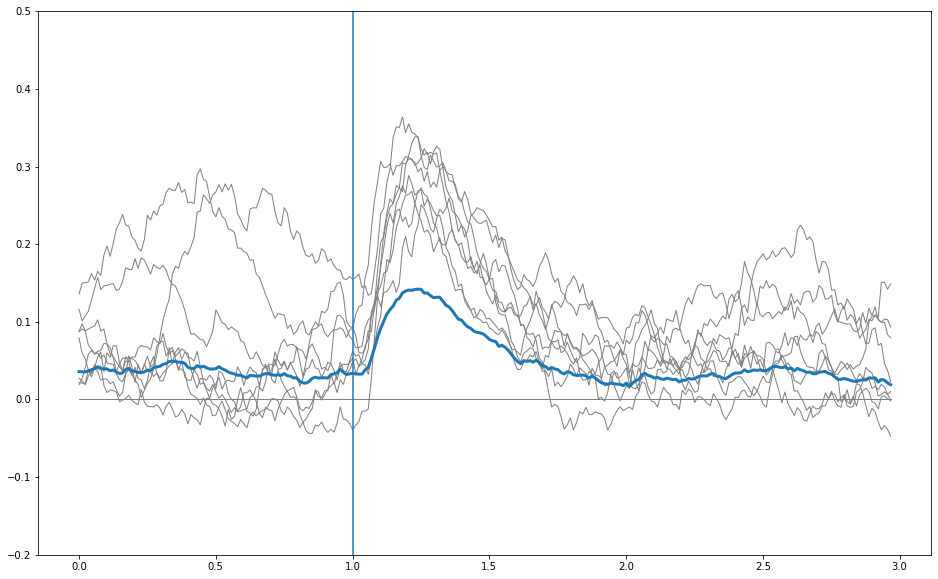

Hotspot_36


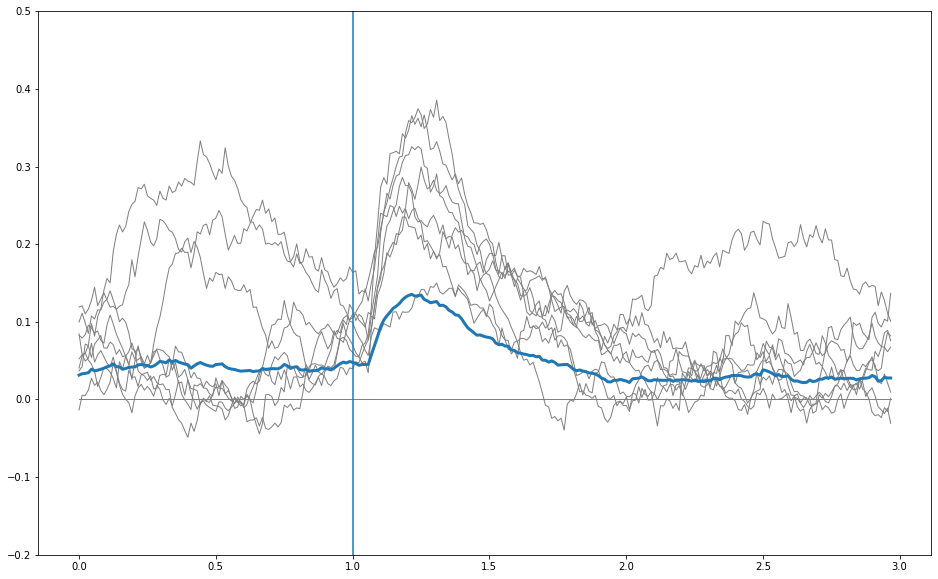

In [67]:
# Scan Images for Visually Invoked Responses
# Image Shape
x, y =DENDRITE.shape


# Dictionary to store hotspots
hotspot= {}
hotspot_max= {}
counter = 1

# Scan small areas across the images, ignoring the border
for i in trange(2, x-2, 2):
    for j in range(2, y-2, 2):
        plotBoolean = False
        
        pixeltrace = stable[:, i:i+2, j:j+2]
        trace = np.nanmean(pixeltrace, axis=(1,2))
        tempDFF = pnf.deltaFOverF0(trace, HZ)
        tempSTD = np.std(tempDFF)
        if STIM_FILE is not None:
            response = np.zeros((len(stim2plot), (int(3*HZ))-1))         
            for stim in stim2plot:
                if tempDFF[int(HZ*stim):].shape[0] > int(HZ*stim)+int(2*HZ):
                    response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim)-int(HZ*1):int(HZ*stim)+int(2*HZ)]
            avg_trace = response.copy() 
            avg_trace[avg_trace==0] ==np.nan  
            avg_trace = np.nanmean(response, axis=0)
            if np.max(avg_trace) > THRESHOLD:
                prepeaks, _ = find_peaks(avg_trace[:int(1*HZ)], prominence=(2*np.std(avg_trace[:int(1*HZ)])+np.mean(avg_trace[:int(1*HZ)])))
                postpeaks, _ = find_peaks(avg_trace[int(1*HZ):], prominence=(2*np.std(avg_trace[:int(1*HZ)])+np.mean(avg_trace[:int(1*HZ)])))

                if (postpeaks.shape[0]>prepeaks.shape[0]) and (postpeaks.shape[0] is not 0):
                        
                        plotBoolean = True
                        hotspot['Hotspot_{}'.format(counter)] = (j, i)
                        hotspot_max['Hotspot_{}'.format(counter)] = np.max(avg_trace)
                        counter += 1
                        
                if plotBoolean == True:
                    avg_time = np.arange(avg_trace.shape[0])/HZ
                    
                    for k in range(response.shape[0]):
                        plt.plot(avg_time, response[k, :], linewidth=1, color='grey')
                    
                    plt.plot(avg_time, avg_trace, linewidth=3)
                    plt.axvline(x=int(1))
                    plt.ylim([-0.2,.5])
                    
                    print('Hotspot_{}'.format(counter-1))
                    plt.show()


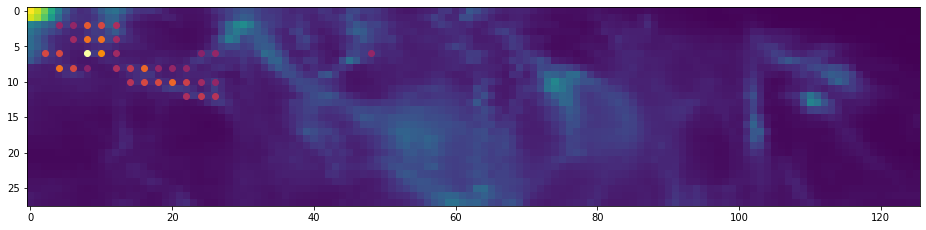

In [107]:

if (len(hotspot_max.values())==0):
    display("No Visually Evoked Hotspots Detected")

else: 
    # Plot Potential Locations of Visually Invoked Responses
    max_peak = (np.max(list(hotspot_max.values())))
    inferno = cm.get_cmap('inferno', len(list(hotspot_max.values())))
    plt.imshow(DENDRITE)
    for key in hotspot.keys():
        plt.plot(hotspot[(key)][0], hotspot[(key)][1], marker='o', color=inferno(hotspot_max[(key)]/max_peak))
    plt.show()

In [68]:
# PAINT THE ROI IN THE NAPARI WINDOW
ROI = np.zeros(DENDRITE.shape)
roi_painter = napari.Viewer()
roi_painter.add_image(DENDRITE)
roi_painter.add_labels(ROI)


<Labels layer 'ROI' at 0x7f801bc1b978>

[0. 1. 2. 3. 4. 5. 6. 7. 8.]


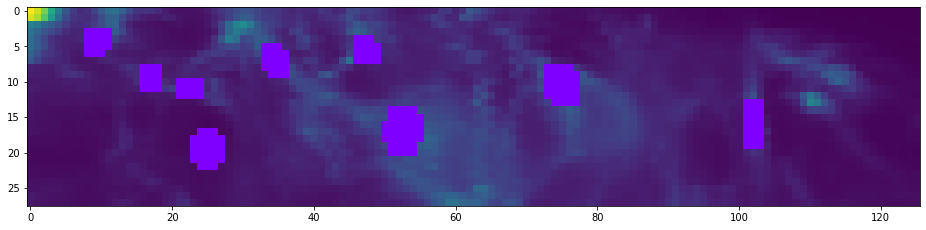

In [69]:
# DISPLAY THE IMAGING AREA AND ROIs
plt.imshow(DENDRITE)
ROI_LABLES = np.unique(ROI)
print(ROI_LABLES)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = np.nan      
        plt.imshow(mask, cmap='rainbow')

In [70]:
# Calculte the DFF for each ROI and save it to a dict

ROI_LABLES = np.unique(ROI)
raw_dict = {}
dff_dict = {}
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        
        # Return the average intensity value for the roi
        roi_trace = returnROITrace(stable, mask)
        
        # Added the trace a to dictionary
        raw_dict[roi] = roi_trace
        
        # Remove shot noise
        roi_trace = pnf.okada(roi_trace)
        
        # Calculate Df/F
        roi_trace = pnf.deltaFOverF0(roi_trace, HZ, None)
        dff_dict[roi] = roi_trace

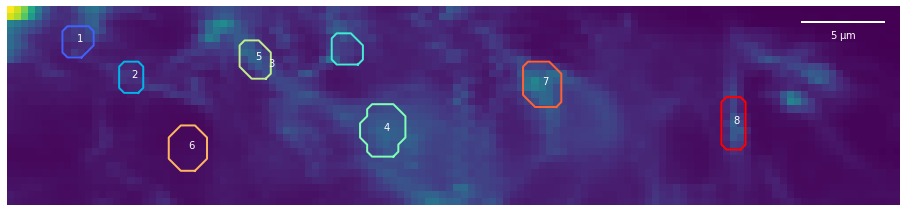

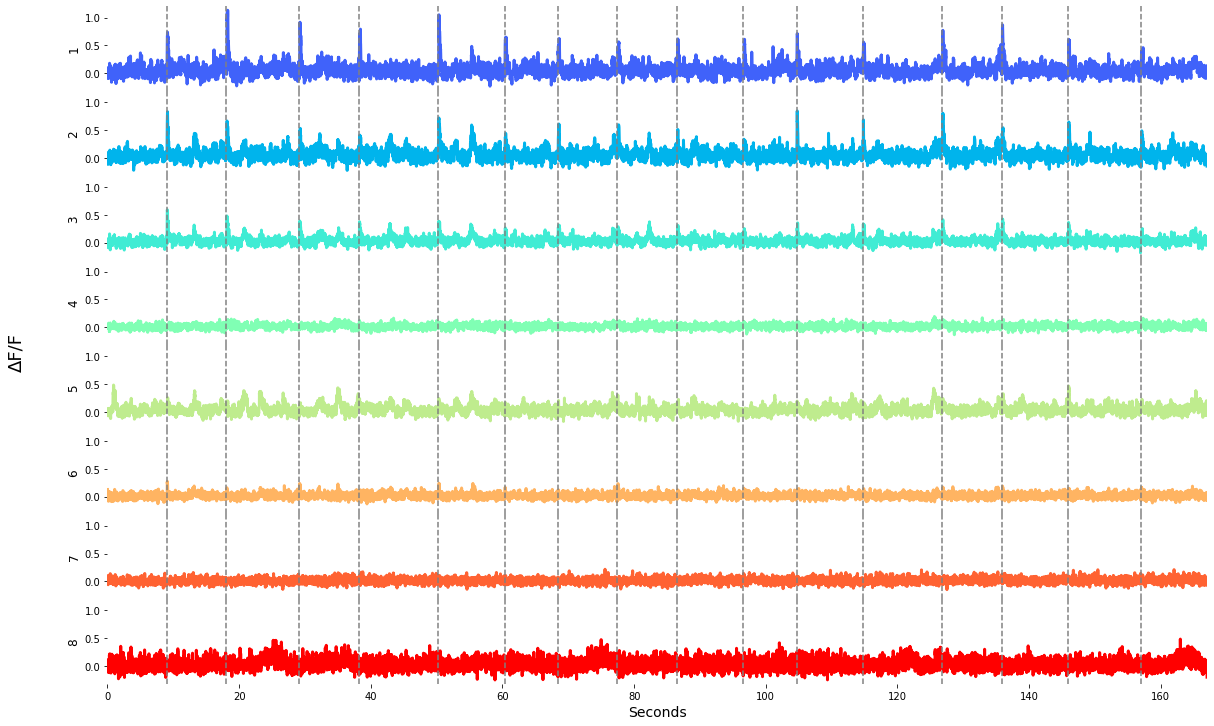

In [77]:
# Graph the ROI overs the STD projection and plot DF/F traces

rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ


fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    PX,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5,
    color ='white'
)
ax1.add_artist(scalebar)

fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,sharey=True, )
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90, fontsize=18)
ax1.imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        com = ndi.measurements.center_of_mass(mask)
        contour = measure.find_contours(mask, .3)
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        ax1.text(com[1],com[0], s=str(int(roi)), color='white')
        
        
        axs[int(roi)-1].plot(time, dff_dict[roi], linewidth=3, color=rainbow(roi/ROI_LABLES.max()))
        axs[int(roi)-1].set_xlim([0,np.max(time)])
        if STIM_FILE is not None:
            for stim in stim2plot:
                axs[int(roi)-1].axvline(x=(stim), ls='--', color='grey')
        axs[int(roi)-1].set_ylabel(str(int(roi)),  fontsize=12)        
        axs[int(roi)-1].spines['top'].set_visible(False)
        axs[int(roi)-1].spines['right'].set_visible(False)
        axs[int(roi)-1].spines['bottom'].set_visible(False)
        axs[int(roi)-1].spines['left'].set_visible(False)
        if int(roi) == (len(ROI_LABLES)-1):
            axs[int(roi)-1].set_xlabel('Seconds',  fontsize=14)
        else:
            axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)

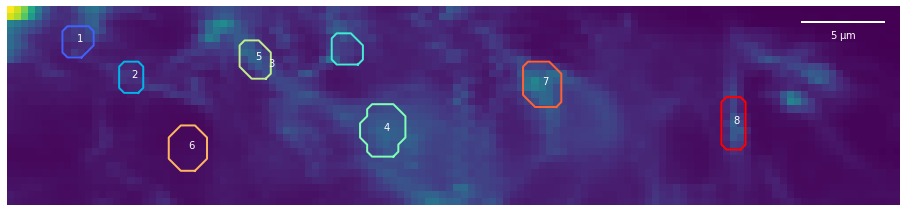

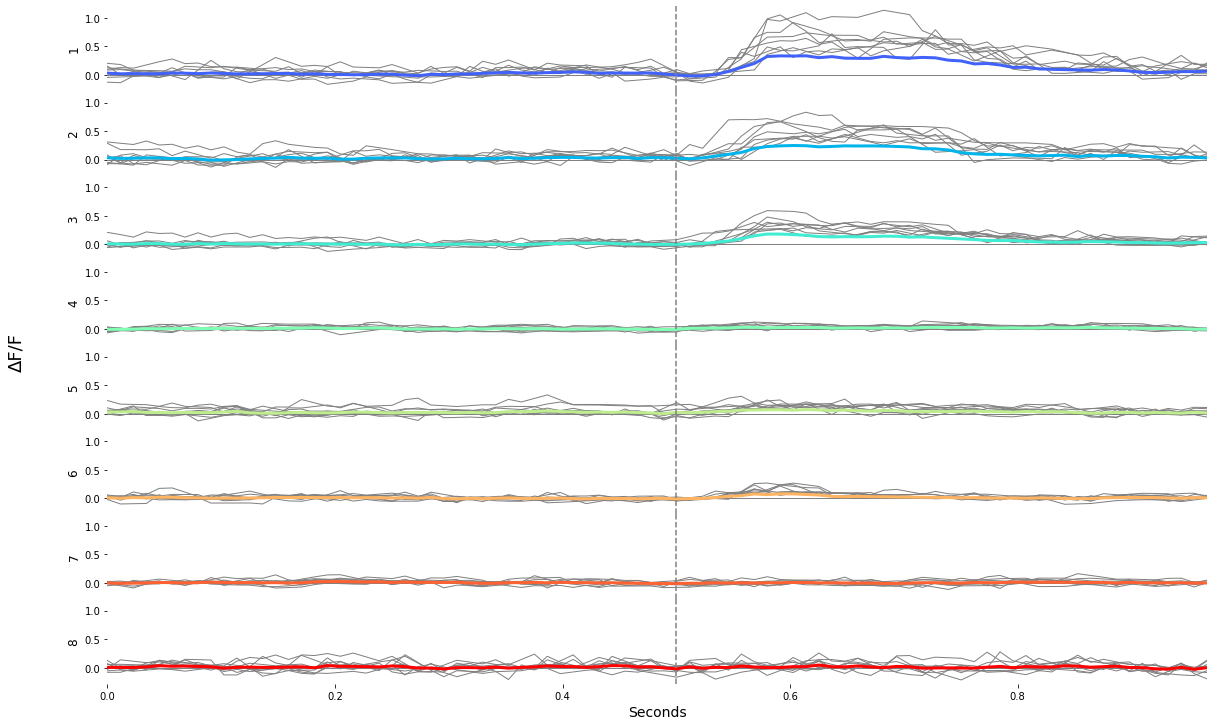

In [78]:
# Graph the ROI overs the STD projection and plot DF/F traces

rainbow = cm.get_cmap('rainbow', len(ROI_LABLES))
time = np.arange(stable.shape[0])/HZ


fig2, ax1 = plt.subplots()
ax1.axis("off")
scalebar = sb.ScaleBar(
    PX,
    "um",
    box_color =None,
    box_alpha=0,
    length_fraction=0.1,
    scale_loc="bottom",
    border_pad=1,
    pad=.5,
    color='white'
)
ax1.add_artist(scalebar)

fig, axs = plt.subplots((len(ROI_LABLES)-1), sharex=True,sharey=True, )
fig.tight_layout()
fig.text(-0.05,0.5, "ΔF/F", ha="center", va="center", rotation=90, fontsize=18)
ax1.imshow(DENDRITE)
for roi in ROI_LABLES:
    if roi > 0:
        # Plot Contours of ROI on the STD Image
        mask = ROI.copy()
        mask[mask!=roi] = 0
        mask[mask!=0] = 1
        # Center of Mass for the ROI label 
        com = ndi.measurements.center_of_mass(mask)
        contour = measure.find_contours(mask, .3)     
        ax1.plot(contour[0][:, 1],contour[0][:, 0], linewidth=2, color=rainbow(roi/ROI_LABLES.max()))
        ax1.text(com[1],com[0], s=str(int(roi)), color='white')
        
        # Get DFF Trace to Get Average Signal After Stim
        tempDFF = dff_dict[roi].copy()
        if STIM_FILE is not None:
            response = np.zeros((len(stim2plot), (int(1*HZ))-1))         
            for stim in stim2plot:
                if tempDFF[int(HZ*stim):].shape[0] > int(HZ*stim)+int(1.5*HZ):
                    response[stim2plot.index(stim), :] = tempDFF[int(HZ*stim)-int(HZ*.5):int(HZ*stim)+int(.5*HZ)]
            avg_trace = response.copy() 
            avg_trace[avg_trace==0] ==np.nan
            avg_trace = np.nanmean(response, axis=0)
            avg_time = np.arange(avg_trace.shape[0])/HZ

            for k in range(response.shape[0]):
                 axs[int(roi)-1].plot(avg_time, response[k, :], linewidth=1, color='grey')

            axs[int(roi)-1].plot(avg_time, avg_trace, linewidth=3, color=rainbow(roi/ROI_LABLES.max()))
            axs[int(roi)-1].axvline(x=0.5, color='grey', ls='--')      
            axs[int(roi)-1].set_xlim([0,np.max(avg_time)])
            axs[int(roi)-1].set_ylabel(str(int(roi)),  fontsize=12)        
            axs[int(roi)-1].spines['top'].set_visible(False)
            axs[int(roi)-1].spines['right'].set_visible(False)
            axs[int(roi)-1].spines['bottom'].set_visible(False)
            axs[int(roi)-1].spines['left'].set_visible(False)
            if int(roi) == (len(ROI_LABLES)-1):
                axs[int(roi)-1].set_xlabel('Seconds',  fontsize=14)
            else:
                axs[int(roi)-1].xaxis.set_ticks_position('none')

plt.subplots_adjust(wspace=0, hspace=0)

In [97]:
# Save the drawn ROI for use later 
time_stamp = str(datetime.datetime.now())
time_stamp = time_stamp.replace(':', '')
filename = (os.path.splitext(os.path.basename(FILE))[0])

# Unique File Identifier with timestamp 
ufID = 'ROI_LABELS_%s_%s' %(filename, time_stamp)

# Create Directory to store ROI
if not os.path.exists('saved_rois'):
    os.mkdir('saved_rois')

# Save ROI 
np.save("saved_rois/%s"%(ufID), ROI)